# Crop AVISO Eddy Dataset to G4 Domain

Run on cluster w/ environment py3_parcels_v2

v3: Cleaned up script

Lexi Jones-Kellett

Date created: 04/17/24

Last edited: 08/12/25

In [1]:
import csv,math
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.image as image
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from shapely.ops import nearest_points
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from config import *

In [2]:
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

SLA eddy boundaries downloaded from AVISO: https://www.aviso.altimetry.fr/en/data/products/value-added-products/global-mesoscale-eddy-trajectory-product/meta3-2-dt.html

In [3]:
ds_anti = xr.open_dataset(AVISO_dir + 'META3.2_DT_allsat_Anticyclonic_long_19930101_20220209.nc')
ds_cyc = xr.open_dataset(AVISO_dir + 'META3.2_DT_allsat_Cyclonic_long_19930101_20220209.nc')
ds_anti

<xarray.Dataset>
Dimensions:                        (NbSample: 20, obs: 34521490)
Dimensions without coordinates: NbSample, obs
Data variables:
    amplitude                      (obs) float32 ...
    cost_association               (obs) float32 ...
    effective_area                 (obs) float32 ...
    effective_contour_height       (obs) float32 ...
    effective_contour_latitude     (obs, NbSample) float32 ...
    effective_contour_longitude    (obs, NbSample) float32 ...
    effective_contour_shape_error  (obs) float32 ...
    effective_radius               (obs) float32 ...
    inner_contour_height           (obs) float32 ...
    latitude                       (obs) float32 ...
    latitude_max                   (obs) float32 ...
    longitude                      (obs) float32 ...
    longitude_max                  (obs) float32 ...
    num_contours                   (obs) uint16 ...
    num_point_e                    (obs) uint16 ...
    num_point_s                    (obs) uint16 ...
    observation_flag               (obs) int8 ...
    observation_number             (obs) uint16 ...
    speed_area                     (obs) float32 ...
    speed_average                  (obs) float32 ...
    speed_contour_height           (obs) float32 ...
    speed_contour_latitude         (obs, NbSample) float32 ...
    speed_contour_longitude        (obs, NbSample) float32 ...
    speed_contour_shape_error      (obs) float32 ...
    speed_radius                   (obs) float32 ...
    time                           (obs) datetime64[ns] ...
    track                          (obs) uint32 ...
    uavg_profile                   (obs, NbSample) float32 ...
Attributes:
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Anticyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T20:56:43Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

In [4]:
unique_dates = np.unique(ds_anti.time)
max(unique_dates) # last date available in the ds

numpy.datetime64('2022-02-09T00:00:00.000000000')

Set bounds based on G4 cruise 

In [5]:
lat_min,lat_max = 15,33
lon_min,lon_max = 215,250

In [6]:
subset_inds = np.where(((ds_anti.latitude > lat_min) & (ds_anti.latitude < lat_max)) & 
                       ((ds_anti.longitude > lon_min) & (ds_anti.longitude < lon_max)) & 
                       ((ds_anti.time) >= np.datetime64('2021-11-19')) &
                       ((ds_anti.time) <= np.datetime64('2021-11-27')))[0]
print(len(subset_inds))

558


In [7]:
# This takes a hot second to run
lat,lon,time,track = [],[],[],[]
for i in subset_inds: 
    this_track_id = int(ds_anti.track[i].values)
    if ds_anti.longitude[i] > 360:
        lon.append(float((ds_anti.longitude[i] - 360).values))
    else:
        lon.append(float(ds_anti.longitude[i].values))
    lat.append(float(ds_anti.latitude[i].values))
    time.append(np.datetime64(ds_anti.time[i].values))
    track.append(this_track_id)

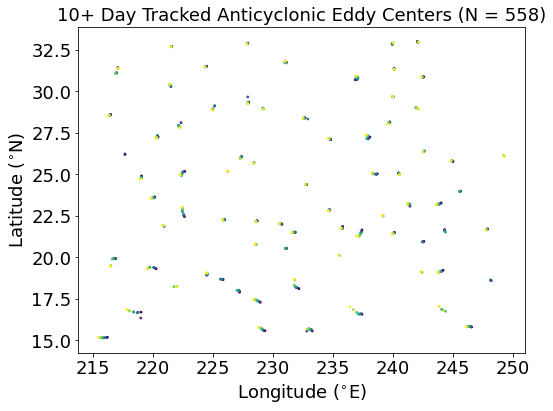

In [8]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.scatter(lon,lat,s=3,c=time)
scat = ax.set_title('10+ Day Tracked Anticyclonic Eddy Centers (N = %s)'%(len(track)))
ax.set_xlabel('Longitude ($^{\circ}$E)');
ax.set_ylabel('Latitude ($^{\circ}$N)');

In [9]:
metadata = []
with open(data_dir + 'G4_metadata_no_physics_25km_near_eddy_threshold.csv') as csv_file: # later update to 15km as "near eddy"
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if (row[0] == '63') or (row[0] == '65'):
            pass
        else:
            metadata.append(row)
metadata = np.array(metadata)
metadata[0]

array(['sample_id', 'date', 'time_UTC', 'latitude', 'longitude',
       'in_anti', 'near_anti', 'in_cyc', 'near_cyc'], dtype='<U9')

In [10]:
dates = np.unique([i[1] for i in metadata[1:-1]]) # exclude header and last milliq blank

In [11]:
df = pd.DataFrame(metadata)
df.columns = df.iloc[0]
df = df[1:]
df = df[df['latitude'].ne('nan')]
df

,sample_id,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc
1,3,20211119,11:04,31.835,241.3917,0,0,0,0
2,4,20211119,13:10,31.575,240.9592,0,0,0,0
3,5,20211119,15:19,31.3125,240.4938,0,0,0,0
4,6,20211119,17:11,31.085,240.1052,0,0,0,0
5,7,20211119,19:04,30.8575,239.7167,0,0,0,0
...,...,...,...,...,...,...,...,...,...
63,67,20211126,20:58,17.282,219.9525,0,0,0,3647
64,68,20211126,23:04,16.8736,219.995,0,0,0,0
65,69,20211127,01:02,16.4513,219.9996,0,0,0,0
66,70,20211127,03:00,16.036,219.9977,0,0,0,0


#### Calculate distances between samples

In [12]:
def distance_from_lat_lon(lat1,lon1,lat2,lon2):
    """
    Returns the distance in kilometers between two coordinate points. Accepts negative (-180 to 180) or positive coordinate systems (0 to 360). 

    lat1,lon1: coordinates for point 1
    lat2,lon2: coordinates for point 2
    """

    R = 6371 # Radius of the earth in km
    delta_lat,delta_lon = math.radians(lat2-lat1),math.radians(lon2-lon1)
    lat1_radians,lat2_radians = math.radians(lat1),math.radians(lat2)
    
    a = math.sin(delta_lat/2) * math.sin(delta_lat/2) + math.cos(lat1_radians) * math.cos(lat2_radians) * ((math.sin(delta_lon/2))**2)
    dist = R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a)) # Distance in km
    
    return dist

#### AVISO Eddy IDs

In [13]:
anti_IDs = ['799642','799833']
cyc_IDs = ['838480','846424','849094','831329','844202','823188','847844','845344']

Check lifespan of each of the eddies

In [14]:
for a in anti_IDs:
    print('Anti eddy ID %s: %s days'%(a,len(np.where(ds_anti.track == int(a))[0])))

Anti eddy ID 799642: 92 days
Anti eddy ID 799833: 56 days


In [15]:
for a in cyc_IDs:
    print('Cyc eddy ID %s: %s days'%(a,len(np.where(ds_cyc.track == int(a))[0])))

Cyc eddy ID 838480: 150 days
Cyc eddy ID 846424: 115 days
Cyc eddy ID 849094: 26 days
Cyc eddy ID 831329: 304 days
Cyc eddy ID 844202: 142 days
Cyc eddy ID 823188: 404 days
Cyc eddy ID 847844: 95 days
Cyc eddy ID 845344: 128 days


### Plot transect

Note: Some samples were taken on different days within the same eddy, so have to make a manual choice of which contour to plot. Choosing the middle date when possible.

In [16]:
def dimension_edges(dim_array):
    adjustment = float(dim_array[1]-dim_array[0])/2
    adjusted_array = [float(i)-adjustment for i in dim_array]
    adjusted_array.append(dim_array[-1]+adjustment)
    return np.array(adjusted_array)

35956321
36274799
36274800
35655569
36372359
35655570
36189622
35307654
36189623
35307655
36326589
36234371
36326591
36234372


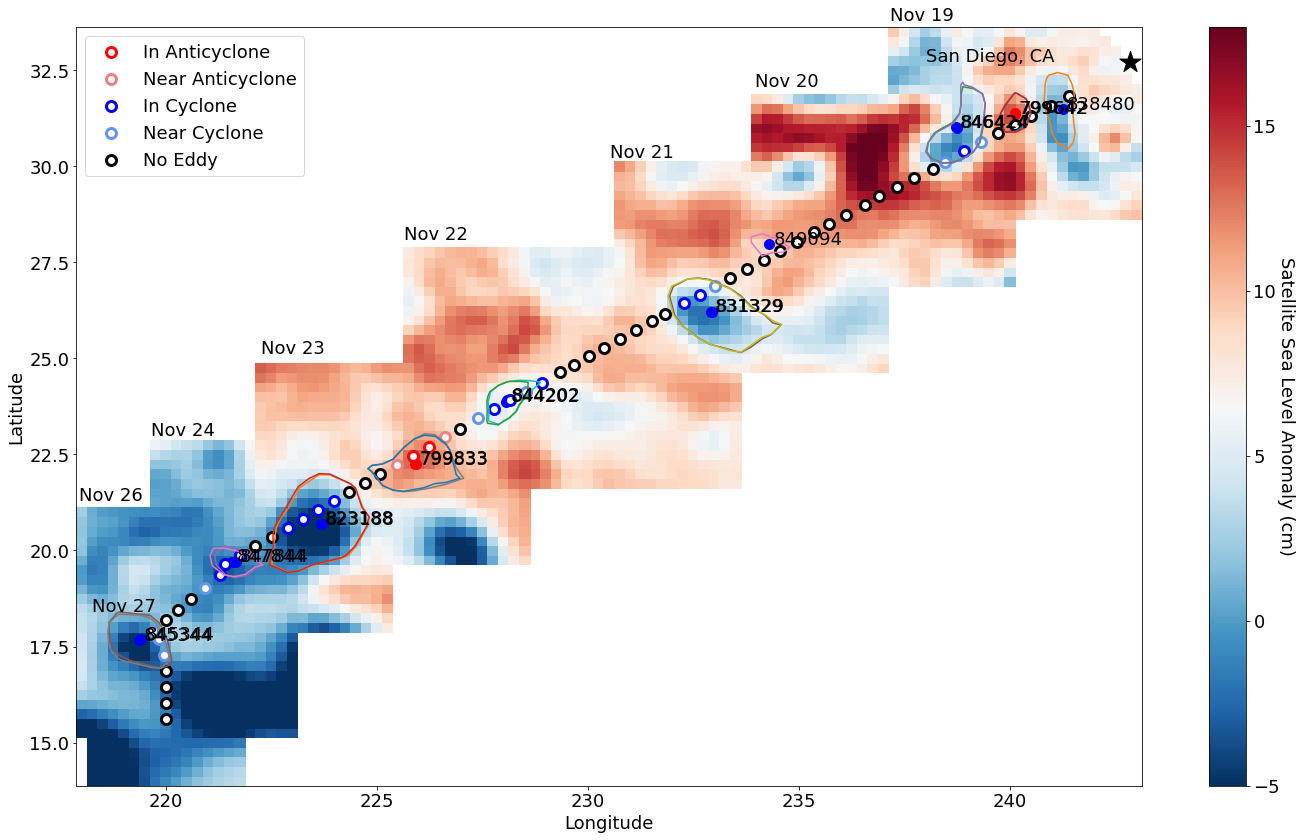

In [17]:
fig,ax = plt.subplots(1,1,figsize=(20,12))

for d in dates:
    date_specific_metadata = np.array(metadata)[np.where([i[1]==d for i in np.array(metadata)])]
    lats = [float(m[3]) for m in date_specific_metadata if m[3] != 'nan']
    lons = [float(m[4]) for m in date_specific_metadata if m[4] != 'nan']

    CMEMS = xr.open_dataset(data_dir + 'CMEMS_data/dt_global_allsat_phy_l4_%s.nc'%(d)) 
    CMEMS_lon_edges = dimension_edges(CMEMS.longitude)
    CMEMS_lat_edges = dimension_edges(CMEMS.latitude)

    buffer = 1.75
    lon_min,lon_max = min(lons)-buffer,max(lons)+buffer
    lat_min,lat_max = min(lats)-buffer,max(lats)+buffer
    lon_inds = np.where((CMEMS_lon_edges >= lon_min) & (CMEMS_lon_edges <= lon_max))
    lat_inds = np.where((CMEMS_lat_edges >= lat_min) & (CMEMS_lat_edges <= lat_max))
    
    # AVISO eddy
    anti_subset_inds = np.where(((ds_anti.latitude > lat_min) & (ds_anti.latitude < lat_max)) & 
                       ((ds_anti.longitude > lon_min) & (ds_anti.longitude < lon_max)) & 
                       ((ds_anti.time) == np.datetime64('%s-%s-%s'%(d[0:4],d[4:6],d[6:8]))))[0]
    for i in anti_subset_inds: 
        if str(ds_anti.track[i].values) in anti_IDs:
            ax.scatter(ds_anti.longitude[i],ds_anti.latitude[i],c='r',s=100)
            contour_lons = ds_anti.effective_contour_longitude[i]
            contour_lats = ds_anti.effective_contour_latitude[i]
            ax.plot(contour_lons,contour_lats)
            ax.text(ds_anti.longitude[i]+0.1,ds_anti.latitude[i],ds_anti.track[i].values,c='k')

    cyc_subset_inds = np.where(((ds_cyc.latitude > lat_min) & (ds_cyc.latitude < lat_max)) & 
                       ((ds_cyc.longitude > lon_min) & (ds_cyc.longitude < lon_max)) & 
                       ((ds_cyc.time) == np.datetime64('%s-%s-%s'%(d[0:4],d[4:6],d[6:8]))))[0]
    for i in cyc_subset_inds: 
        if str(ds_cyc.track[i].values) in cyc_IDs:
            print(i)
            ax.scatter(ds_cyc.longitude[i],ds_cyc.latitude[i],c='b',s=100)
            contour_lons = ds_cyc.effective_contour_longitude[i]
            contour_lats = ds_cyc.effective_contour_latitude[i]
            ax.plot(contour_lons,contour_lats)
            ax.text(ds_cyc.longitude[i]+0.1,ds_cyc.latitude[i],ds_cyc.track[i].values,c='k')
    
    
    # Plot the date
    ax.text(min(lons)-buffer,max(lats)+buffer+0.2,'Nov %s'%(d[6:8]),fontsize=fontsize,color='k')
        
    # Plot SLA
    sla_plot = ax.pcolormesh(CMEMS_lon_edges[lon_inds],
                            CMEMS_lat_edges[lat_inds],
                            CMEMS.sla[0,lat_inds[0],lon_inds[0]]*100,
                            cmap='RdBu_r',vmin=-5,vmax=18,zorder=0,shading='nearest')
    
    #ax.scatter(lons,lats,s=50,c='w',edgecolor='k',zorder=100);
#for i in df.index:
#    ax.text(float(df.loc[i]['longitude'])+0.25,float(df.loc[i]['latitude'])-0.25,df.loc[i]['sample_id'],fontsize=18)

linewidth = 3
scat_size = 100

ax.scatter([float(i) for i in df[df["in_anti"].ne('0')]["longitude"].tolist()],
           [float(i) for i in df[df["in_anti"].ne('0')]["latitude"].tolist()],
          c='white',edgecolor='red',linewidth=linewidth,s=scat_size,label='In Anticyclone')

ax.scatter([float(i) for i in df[df["near_anti"].ne('0')]["longitude"].tolist()],
           [float(i) for i in df[df["near_anti"].ne('0')]["latitude"].tolist()],
          c='white',edgecolor='lightcoral',linewidth=linewidth,s=scat_size,label='Near Anticyclone')

ax.scatter([float(i) for i in df[df["in_cyc"].ne('0')]["longitude"].tolist()],
           [float(i) for i in df[df["in_cyc"].ne('0')]["latitude"].tolist()],
          c='white',edgecolor='blue',linewidth=linewidth,s=scat_size,label='In Cyclone')

ax.scatter([float(i) for i in df[df["near_cyc"].ne('0')]["longitude"].tolist()],
           [float(i) for i in df[df["near_cyc"].ne('0')]["latitude"].tolist()],
          c='white',edgecolor='cornflowerblue',linewidth=linewidth,s=scat_size,label='Near Cyclone')

ax.scatter([float(i) for i in df[df["near_cyc"].eq('0') & df["near_anti"].eq('0') & df["in_cyc"].eq('0') & df["in_anti"].eq('0')]["longitude"].tolist()],
           [float(i) for i in df[df["near_cyc"].eq('0') & df["near_anti"].eq('0') & df["in_cyc"].eq('0') & df["in_anti"].eq('0')]["latitude"].tolist()],
            c='white',edgecolor='k',linewidth=linewidth,s=scat_size,label='No Eddy')

ax.scatter(360-117.1611,32.7157,marker='*',c='k',s=500)
ax.text(360-122,32.7157,'San Diego, CA',fontsize=fontsize)
    
#SLA Colorbar
sla_cbar = plt.colorbar(sla_plot,ax=ax)
sla_cbar.ax.tick_params(labelsize=fontsize)
sla_cbar.set_label('Satellite Sea Level Anomaly (cm)',rotation=270,fontsize=fontsize,labelpad=15)

#Figure params
ax.set_xlabel("Longitude",fontsize=fontsize);
ax.set_ylabel("Latitude",fontsize=fontsize);
ax.tick_params(axis='both', which='major', labelsize=fontsize);

plt.legend(fontsize=fontsize)

plt.tight_layout()

#### Classify stations by AVISO eddies

In [18]:
def distance_from_lat_lon(lat1,lon1,lat2,lon2):
    R = 6371 # Radius of the earth in km
    delta_lat,delta_lon = math.radians(lat2-lat1),math.radians(lon2-lon1)
    lat1_radians,lat2_radians = math.radians(lat1),math.radians(lat2)
    
    a = math.sin(delta_lat/2) * math.sin(delta_lat/2) + math.cos(lat1_radians) * math.cos(lat2_radians) * ((math.sin(delta_lon/2))**2)
    dist = R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a)) # Distance in km
    
    return dist

In [19]:
AVISO_df = df.drop(['in_anti','near_anti','in_cyc','near_cyc'],axis=1)
AVISO_df

,sample_id,date,time_UTC,latitude,longitude
1,3,20211119,11:04,31.835,241.3917
2,4,20211119,13:10,31.575,240.9592
3,5,20211119,15:19,31.3125,240.4938
4,6,20211119,17:11,31.085,240.1052
5,7,20211119,19:04,30.8575,239.7167
...,...,...,...,...,...
63,67,20211126,20:58,17.282,219.9525
64,68,20211126,23:04,16.8736,219.995
65,69,20211127,01:02,16.4513,219.9996
66,70,20211127,03:00,16.036,219.9977


In [20]:
def check_if_in_eddy(d,lon,lat,eddy_data):
    """
    This function gets run for one sample point at a time
    
    Inputs
        date - Format YYYYMMDD
        lat - 10 to 70 (degrees north); latitude of the data point
        lon - input should be positive coordinates (110 to 250 degrees); longitude of the data point
        eddy_array - Name of the eddy dataset to look through (cyc or anti)
        
    Outputs
        0 if point is not in eddy, OR eddy ID if point is in an eddy
    """

    # Define search window
    buffer = 2 # degrees
    lon_min,lon_max = lon-buffer,lon+buffer
    lat_min,lat_max = lat-buffer,lat+buffer
    
    # Subset AVISO eddy dataset
    subset_inds = np.where(((eddy_data.latitude > lat_min) & (eddy_data.latitude < lat_max)) & 
                       ((eddy_data.longitude > lon_min) & (eddy_data.longitude < lon_max)) & 
                       ((eddy_data.time) == np.datetime64('%s-%s-%s'%(d[0:4],d[4:6],d[6:8]))))[0]
    
    # Iterate through eddies in search window
    in_eddy,near_eddy = 0,0 #flag to determine if the point is in an eddy
    i = 0 #counter
    for i in subset_inds: 
        contour_lons = np.array(eddy_data.effective_contour_longitude[i].values)
        contour_lats = np.array(eddy_data.effective_contour_latitude[i].values)
    
        #Check if the point is far away from the eddy we are checking right now, and if so, skip to the next eddy
        if lon > np.max(contour_lons)+1 or lon < np.min(contour_lons)-1 or lat > np.max(contour_lats)+1 or lat < np.min(contour_lats)-1:
            i += 1 #have to step up the counter here because the loop will skip the rest of the code here
            continue
        
        #If the point is close to the eddy, reformat the data so it is readable by the Polygon function
        poly_pts = [(contour_lons[pt],contour_lats[pt]) for pt in np.arange(0,len(contour_lons))]
        polygon = Polygon(poly_pts)
        data_pt = Point(lon,lat)
        
        if polygon.contains(data_pt):
            in_eddy = int(eddy_data.track[i].values)
            break
        else:
            p1, p2 = nearest_points(polygon, data_pt)
            dist_km = distance_from_lat_lon(lat,lon,p1.y,p1.x)
            if dist_km < 15: #NOTE: Changed 04/04/25 from 25 to 15
                near_eddy = int(eddy_data.track[i].values)
        i += 1
    
    return in_eddy,near_eddy

In [21]:
in_anti,near_anti,in_cyc,near_cyc = [],[],[],[]

for index, row in AVISO_df.iterrows():    
    sample_date = str(row['date'])
    sample_lon = float(row['longitude'])
    sample_lat = float(row['latitude'])
    
    anti_eddy_check,anti_near_eddy_check = check_if_in_eddy(sample_date,sample_lon,sample_lat,ds_anti)
    in_anti.append(anti_eddy_check)
    near_anti.append(anti_near_eddy_check)
    
    cyc_eddy_check,cyc_near_eddy_check = check_if_in_eddy(sample_date,sample_lon,sample_lat,ds_cyc)
    in_cyc.append(cyc_eddy_check)
    near_cyc.append(cyc_near_eddy_check)

In [22]:
AVISO_df['in_anti'] = in_anti
AVISO_df['near_anti'] = near_anti
AVISO_df['in_cyc'] = in_cyc
AVISO_df['near_cyc'] = near_cyc

In [23]:
AVISO_df.head()

,sample_id,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc
1,3,20211119,11:04,31.835,241.3917,0,0,838480,0
2,4,20211119,13:10,31.575,240.9592,0,0,838480,0
3,5,20211119,15:19,31.3125,240.4938,0,799642,0,0
4,6,20211119,17:11,31.085,240.1052,799642,0,0,0
5,7,20211119,19:04,30.8575,239.7167,0,0,0,0


In [24]:
#AVISO_df.to_csv(data_dir + 'AVISO_eddies/AVISO_metadata_15km_near_eddy.csv')

In [25]:
G4_AVISO_anti_dict = {}
G4_AVISO_cyc_dict = {}

for index, row in AVISO_df.iterrows():    
    if row['in_anti'] != 0:
        if row['date'] not in G4_AVISO_anti_dict:
            G4_AVISO_anti_dict[row['date']] = [row['in_anti']]
        elif row['date'] in G4_AVISO_anti_dict:
            if row['in_anti'] not in G4_AVISO_anti_dict[row['date']]:
                G4_AVISO_anti_dict[row['date']].append(row['in_anti'])

    if row['near_anti'] != 0:
        if row['date'] not in G4_AVISO_anti_dict:
            G4_AVISO_anti_dict[row['date']] = [row['near_anti']]
        elif row['date'] in G4_AVISO_anti_dict:
            if row['near_anti'] not in G4_AVISO_anti_dict[row['date']]:
                G4_AVISO_anti_dict[row['date']].append(row['near_anti'])
    
    if row['in_cyc'] != 0:
        if row['date'] not in G4_AVISO_cyc_dict:
            G4_AVISO_cyc_dict[row['date']] = [row['in_cyc']]
        elif row['date'] in G4_AVISO_cyc_dict:
            if row['in_cyc'] not in G4_AVISO_cyc_dict[row['date']]:
                G4_AVISO_cyc_dict[row['date']].append(row['in_cyc'])

    if row['near_cyc'] != 0:
        if row['date'] not in G4_AVISO_cyc_dict:
            G4_AVISO_cyc_dict[row['date']] = [row['near_cyc']]
        elif row['date'] in G4_AVISO_cyc_dict:
            if row['near_cyc'] not in G4_AVISO_cyc_dict[row['date']]:
                G4_AVISO_cyc_dict[row['date']].append(row['near_cyc'])

In [26]:
G4_AVISO_anti_dict

{'20211119': [799642], '20211123': [799833]}

In [27]:
G4_AVISO_cyc_dict

{'20211119': [838480, 846424],
 '20211120': [846424],
 '20211121': [849094, 831329],
 '20211122': [844202],
 '20211123': [823188],
 '20211124': [823188, 847844],
 '20211126': [847844, 845344]}

#### Calculate eddy age during G4 crossings

Data for Eddy Info Table 

In [28]:
for d in dates:
    try:
        anti_tracks = G4_AVISO_anti_dict[d]
        for a in anti_tracks:
            track_inds = np.where(ds_anti.track == int(a))[0]
            crossing_ind = np.where(((ds_anti.track == a) & ((ds_anti.time) == np.datetime64('%s-%s-%s'%(d[0:4],d[4:6],d[6:8])))))[0][0]    
            print('Anti eddy ID %s: %s / %s days'%(a,np.where(track_inds == crossing_ind)[0][0] + 1, len(track_inds)))
            print('Birth: %s'%(ds_anti.time[track_inds[0]].values))            
            print('Death: %s'%(ds_anti.time[track_inds[-1]].values))

    except:
        pass
    
    try:
        cyc_tracks = G4_AVISO_cyc_dict[d]
        for a in cyc_tracks:
            track_inds = np.where(ds_cyc.track == int(a))[0]
            crossing_ind = np.where(((ds_cyc.track == a) & ((ds_cyc.time) == np.datetime64('%s-%s-%s'%(d[0:4],d[4:6],d[6:8])))))[0][0]    
            print('Cyc eddy ID %s: %s / %s days'%(a,np.where(track_inds == crossing_ind)[0][0] + 1, len(track_inds)))
            print('Birth: %s'%(ds_cyc.time[track_inds[0]].values))            
            print('Death: %s'%(ds_cyc.time[track_inds[-1]].values))
    except:
        pass

Anti eddy ID 799642: 10 / 92 days
Birth: 2021-11-10T00:00:00.000000000
Death: 2022-02-09T00:00:00.000000000
Cyc eddy ID 838480: 131 / 150 days
Birth: 2021-07-12T00:00:00.000000000
Death: 2021-12-08T00:00:00.000000000
Cyc eddy ID 846424: 33 / 115 days
Birth: 2021-10-18T00:00:00.000000000
Death: 2022-02-09T00:00:00.000000000
Cyc eddy ID 846424: 34 / 115 days
Birth: 2021-10-18T00:00:00.000000000
Death: 2022-02-09T00:00:00.000000000
Cyc eddy ID 849094: 1 / 26 days
Birth: 2021-11-21T00:00:00.000000000
Death: 2021-12-16T00:00:00.000000000
Cyc eddy ID 831329: 224 / 304 days
Birth: 2021-04-12T00:00:00.000000000
Death: 2022-02-09T00:00:00.000000000
Cyc eddy ID 844202: 63 / 142 days
Birth: 2021-09-21T00:00:00.000000000
Death: 2022-02-09T00:00:00.000000000
Anti eddy ID 799833: 12 / 56 days
Birth: 2021-11-12T00:00:00.000000000
Death: 2022-01-06T00:00:00.000000000
Cyc eddy ID 823188: 326 / 404 days
Birth: 2021-01-02T00:00:00.000000000
Death: 2022-02-09T00:00:00.000000000
Cyc eddy ID 823188: 327 / 4

#### Save eddy data in table

In [29]:
anti_table = [['Date','Eddy ID','Age (days)','Age (frac of life)','Speed (m/s)','Center Lon','Center Lat','Contour Lons','Contour Lats']]
cyc_table = [['Date','Eddy ID','Age (days)','Age (frac of life)','Speed (m/s)','Center Lon','Center Lat','Contour Lons','Contour Lats']]

for d in dates:
    try: # check if there's any antis today
        anti_tracks = G4_AVISO_anti_dict[d]
        for a in anti_tracks:
            track_inds = np.where(ds_anti.track == int(a))[0]
            crossing_ind = np.where(((ds_anti.track == a) & ((ds_anti.time) == np.datetime64('%s-%s-%s'%(d[0:4],d[4:6],d[6:8])))))[0][0]  
            age = np.where(track_inds == crossing_ind)[0][0] + 1
            
            anti_table.append([d,a,age,age/len(track_inds),float(ds_anti.speed_average[crossing_ind].values),
                               float(ds_anti.longitude[crossing_ind].values),float(ds_anti.latitude[crossing_ind].values),
                              list(ds_anti.effective_contour_longitude[crossing_ind].values),list(ds_anti.effective_contour_latitude[crossing_ind].values)])

    except:
        pass
    
    try: # check if there's any cycs today
        cyc_tracks = G4_AVISO_cyc_dict[d]
        for a in cyc_tracks:
            track_inds = np.where(ds_cyc.track == int(a))[0]
            crossing_ind = np.where(((ds_cyc.track == a) & ((ds_cyc.time) == np.datetime64('%s-%s-%s'%(d[0:4],d[4:6],d[6:8])))))[0][0]    
            age = np.where(track_inds == crossing_ind)[0][0] + 1
            
            cyc_table.append([d,a,age,age/len(track_inds),float(ds_cyc.speed_average[crossing_ind].values),
                               float(ds_cyc.longitude[crossing_ind].values),float(ds_cyc.latitude[crossing_ind].values),
                              list(ds_cyc.effective_contour_longitude[crossing_ind].values),list(ds_cyc.effective_contour_latitude[crossing_ind].values)])

    except:
        pass

In [30]:
#with open(data_dir + 'AVISO_eddies/AVISO_anti_eddy_G4_crossing_data.csv', 'w', newline='') as f:
#    writer = csv.writer(f)
#    writer.writerows(anti_table)

#with open(data_dir + 'AVISO_eddies/AVISO_cyc_eddy_G4_crossing_data.csv', 'w', newline='') as f:
#    writer = csv.writer(f)
#    writer.writerows(cyc_table)

## Plot Filtered AVISO eddies

In [31]:
G4_AVISO_cyc_dict

{'20211119': [838480, 846424],
 '20211120': [846424],
 '20211121': [849094, 831329],
 '20211122': [844202],
 '20211123': [823188],
 '20211124': [823188, 847844],
 '20211126': [847844, 845344]}

In [32]:
# Manually choose most represented day to plot
G4_AVISO_cyc_dict_refined = {'20211119': [838480],
                             '20211120': [846424],
                             '20211121': [849094, 831329],
                             '20211122': [844202],
                             '20211124': [823188, 847844],
                             '20211126': [845344]}

### Thesis Version Plot

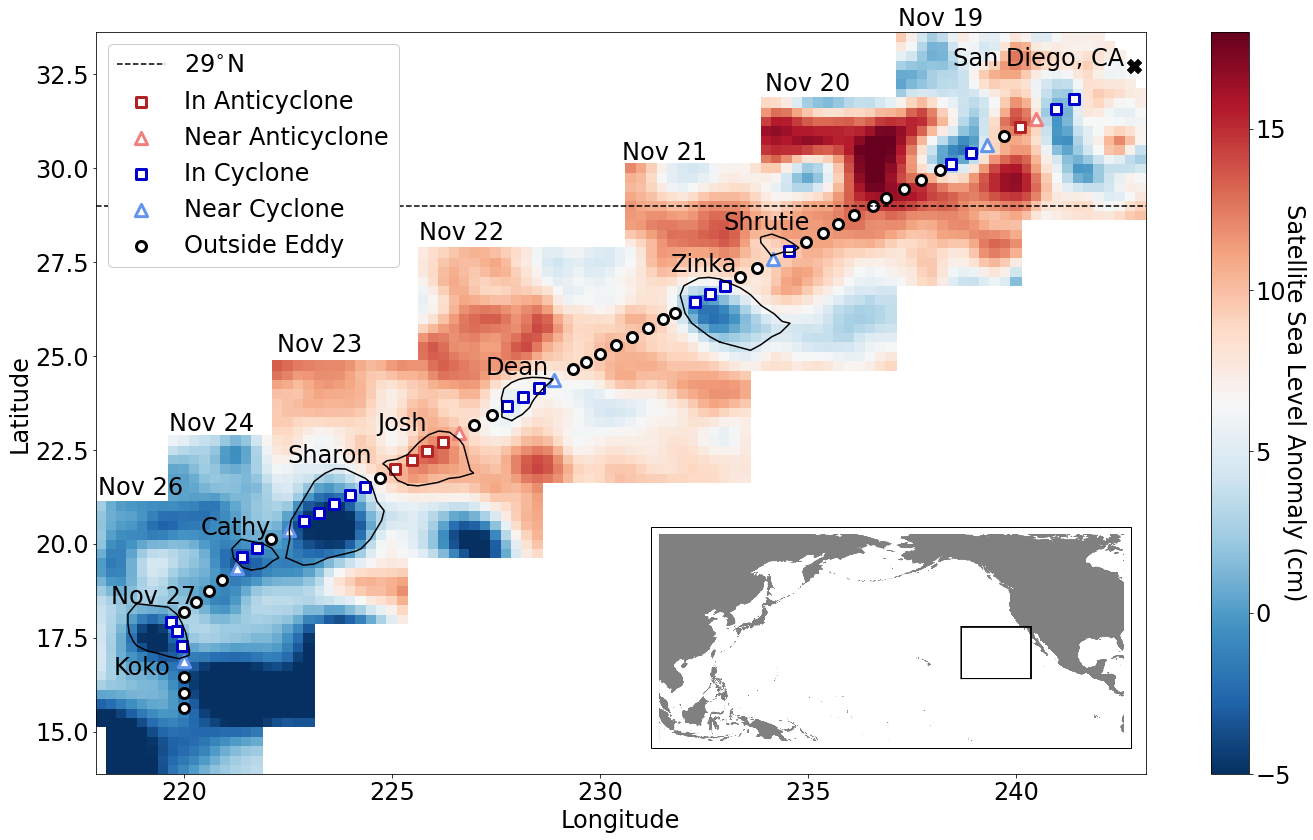

In [33]:
fontsize = 24

fig,ax = plt.subplots(1,1,figsize=(20,12))

for d in dates:
    date_specific_metadata = np.array(metadata)[np.where([i[1]==d for i in np.array(metadata)])]
    lats = [float(m[3]) for m in date_specific_metadata if m[3] != 'nan']
    lons = [float(m[4]) for m in date_specific_metadata if m[4] != 'nan']

    CMEMS = xr.open_dataset(data_dir + 'CMEMS_data/dt_global_allsat_phy_l4_%s.nc'%(d)) 
    CMEMS_lon_edges = dimension_edges(CMEMS.longitude)
    CMEMS_lat_edges = dimension_edges(CMEMS.latitude)

    buffer = 1.75
    lon_min,lon_max = min(lons)-buffer,max(lons)+buffer
    lat_min,lat_max = min(lats)-buffer,max(lats)+buffer
    lon_inds = np.where((CMEMS_lon_edges >= lon_min) & (CMEMS_lon_edges <= lon_max))
    lat_inds = np.where((CMEMS_lat_edges >= lat_min) & (CMEMS_lat_edges <= lat_max))

    
    ############################ PLOT EDDIES ############################
    try:
        anti_tracks = G4_AVISO_anti_dict[d]
        
        anti_subset_inds = []
        for a in anti_tracks:
            anti_subset_inds.append(np.where(((ds_anti.track == a) & ((ds_anti.time) == np.datetime64('%s-%s-%s'%(d[0:4],d[4:6],d[6:8])))))[0][0])
    
        for i in anti_subset_inds: 
            if (ds_anti.track[i].values == 799642): # skip California Current eddy
                pass
            else:
                contour_lons = ds_anti.effective_contour_longitude[i]
                contour_lats = ds_anti.effective_contour_latitude[i]
                ax.plot(contour_lons,contour_lats,c='k')
                #ax.text(ds_anti.longitude[i]+0.1,ds_anti.latitude[i],ds_anti.track[i].values,c='k')                                  
    except: # no eddies today
        pass

    try:
        cyc_tracks = G4_AVISO_cyc_dict_refined[d]
        
        cyc_subset_inds = []
        for a in cyc_tracks:
            cyc_subset_inds.append(np.where(((ds_cyc.track == a) & ((ds_cyc.time) == np.datetime64('%s-%s-%s'%(d[0:4],d[4:6],d[6:8])))))[0][0])
    
        for i in cyc_subset_inds: 
            if (ds_cyc.track[i].values == 838480) or (ds_cyc.track[i].values == 846424): # skip California Current eddies
                pass
            else:
                contour_lons = ds_cyc.effective_contour_longitude[i]
                contour_lats = ds_cyc.effective_contour_latitude[i]
                ax.plot(contour_lons,contour_lats,c='k')
                #ax.text(ds_cyc.longitude[i]+0.1,ds_cyc.latitude[i],ds_cyc.track[i].values,c='k')
    except: # no eddies today
        pass
    
    # Plot the date
    ax.text(min(lons)-buffer,max(lats)+buffer+0.2,'Nov %s'%(d[6:8]),fontsize=fontsize,color='k')
    
    # Plot SLA
    sla_plot = ax.pcolormesh(CMEMS_lon_edges[lon_inds],
                            CMEMS_lat_edges[lat_inds],
                            CMEMS.sla[0,lat_inds[0],lon_inds[0]]*100,
                            cmap='RdBu_r',vmin=-5,vmax=18,zorder=0,shading='nearest')
    
    
linewidth = 3
scat_size = 100

ax.scatter([float(i) for i in AVISO_df[AVISO_df["in_anti"].ne(0)]["longitude"].tolist()],
           [float(i) for i in AVISO_df[AVISO_df["in_anti"].ne(0)]["latitude"].tolist()],
          c='white',edgecolor='firebrick',linewidth=linewidth,s=scat_size,marker='s',label='In Anticyclone')

ax.scatter([float(i) for i in AVISO_df[AVISO_df["near_anti"].ne(0)]["longitude"].tolist()],
           [float(i) for i in AVISO_df[AVISO_df["near_anti"].ne(0)]["latitude"].tolist()],
          c='white',edgecolor='lightcoral',linewidth=linewidth,s=scat_size+50,marker='^',label='Near Anticyclone')

ax.scatter([float(i) for i in AVISO_df[AVISO_df["in_cyc"].ne(0)]["longitude"].tolist()],
           [float(i) for i in AVISO_df[AVISO_df["in_cyc"].ne(0)]["latitude"].tolist()],
          c='white',edgecolor='mediumblue',linewidth=linewidth,s=scat_size,marker='s',label='In Cyclone')

ax.scatter([float(i) for i in AVISO_df[AVISO_df["near_cyc"].ne(0)]["longitude"].tolist()],
           [float(i) for i in AVISO_df[AVISO_df["near_cyc"].ne(0)]["latitude"].tolist()],
          c='white',edgecolor='cornflowerblue',linewidth=linewidth,s=scat_size+50,marker='^',label='Near Cyclone')

ax.scatter([float(i) for i in AVISO_df[AVISO_df["near_cyc"].eq(0) & AVISO_df["near_anti"].eq(0) & AVISO_df["in_cyc"].eq(0) & AVISO_df["in_anti"].eq(0)]["longitude"].tolist()],
           [float(i) for i in AVISO_df[AVISO_df["near_cyc"].eq(0) & AVISO_df["near_anti"].eq(0) & AVISO_df["in_cyc"].eq(0) & AVISO_df["in_anti"].eq(0)]["latitude"].tolist()],
            c='white',edgecolor='k',linewidth=linewidth,s=scat_size,label='Outside Eddy')

ax.scatter(360-117.1611,32.7157,marker='X',c='k',s=200)
ax.text(360-121.5,32.7157,'San Diego, CA',fontsize=fontsize)

ax.axhline(29,c='k',linestyle='--',label='$29^{\circ}$N')

# Plot eddy names
ax.text(234,28.35,'Shrutie',fontsize=fontsize,horizontalalignment='center',color='k')
ax.text(232.5,27.25,'Zinka',fontsize=fontsize,horizontalalignment='center',color='k')
ax.text(228,24.5,'Dean',fontsize=fontsize,horizontalalignment='center',color='k')
ax.text(225.25,23,'Josh',fontsize=fontsize,horizontalalignment='center',color='k')
ax.text(223.5,22.15,'Sharon',fontsize=fontsize,horizontalalignment='center',color='k')
ax.text(221.25,20.25,'Cathy',fontsize=fontsize,horizontalalignment='center',color='k')
ax.text(219,16.5,'Koko',fontsize=fontsize,horizontalalignment='center',color='k')
    
#SLA Colorbar
sla_cbar = plt.colorbar(sla_plot,ax=ax)
sla_cbar.ax.tick_params(labelsize=fontsize)
sla_cbar.set_label('Satellite Sea Level Anomaly (cm)',rotation=270,fontsize=fontsize,labelpad=15)
    
# Map overlay
image_path = data_dir + 'ISME_paper_figs/cropped_global_map_bbox.png'
glob_map = image.imread(image_path)
imagebox = OffsetImage(glob_map, zoom = 0.3)
ab = AnnotationBbox(imagebox, (237, 17.5), frameon = True)
ax.add_artist(ab)

#Figure params
ax.set_xlabel("Longitude",fontsize=fontsize);
ax.set_ylabel("Latitude",fontsize=fontsize);
ax.tick_params(axis='both', which='major', labelsize=fontsize);

plt.legend(fontsize=fontsize,loc='upper left',framealpha=1)
plt.tight_layout()

### SCOPE 2024 Meeting Fig Version

Show Stations instead of my sample sites

In [34]:
station_lats = [32.43,28.436,27.06757,21.7402,19.6381,19.4709,17.875,17.6771,13.95,10.5]
station_lons = [-117.16,-124.403,-126.6738,-135.3133,-138.6148,-138.5788,-140.34375,-140.1620,-140,-140]
station_lons = [i+360 for i in station_lons]
station_labels = ['SD','St. 1','St. 2','St. 3','St. 4','','','St. 5','St. 6','St. 7']

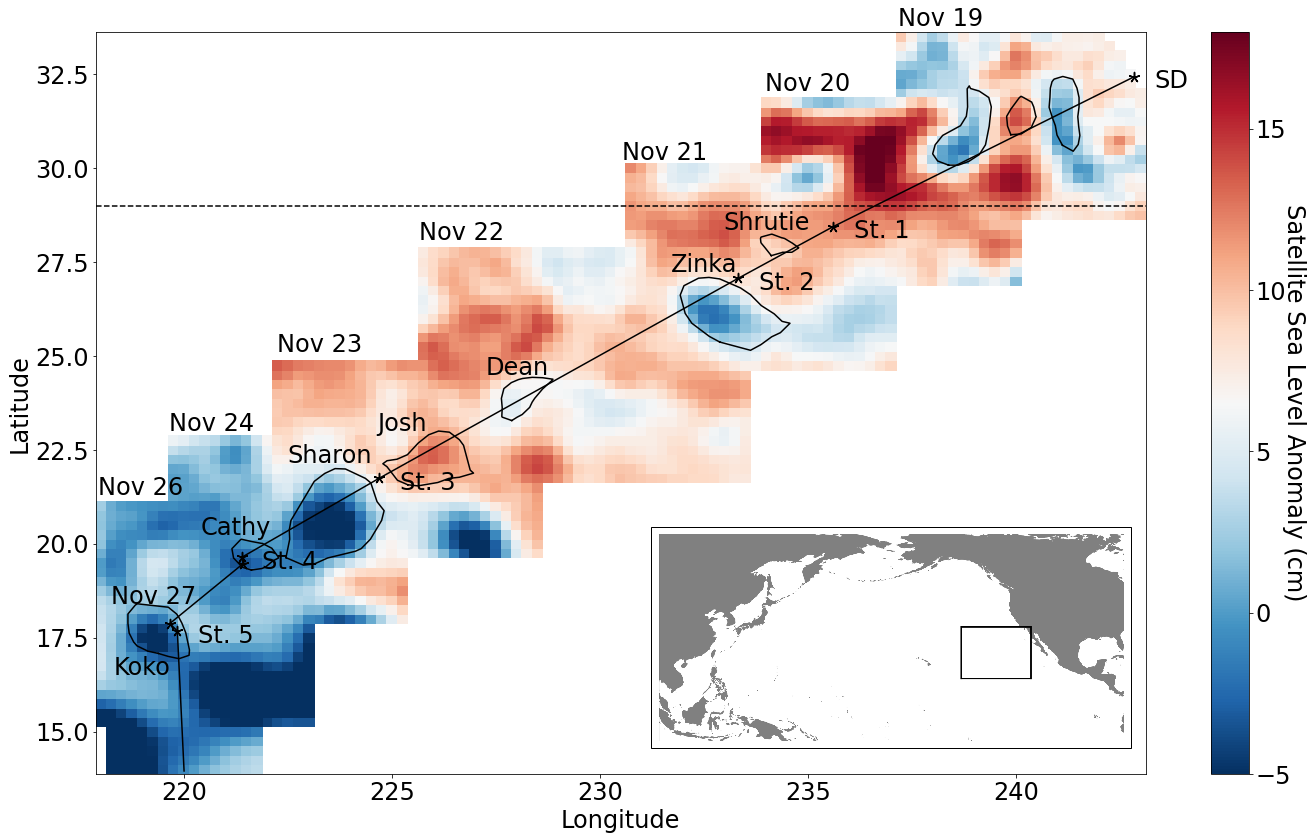

In [35]:
fontsize = 24

fig,ax = plt.subplots(1,1,figsize=(20,12))

for d in dates:
    date_specific_metadata = np.array(metadata)[np.where([i[1]==d for i in np.array(metadata)])]
    lats = [float(m[3]) for m in date_specific_metadata if m[3] != 'nan']
    lons = [float(m[4]) for m in date_specific_metadata if m[4] != 'nan']

    CMEMS = xr.open_dataset(data_dir + 'CMEMS_data/dt_global_allsat_phy_l4_%s.nc'%(d)) 
    CMEMS_lon_edges = dimension_edges(CMEMS.longitude)
    CMEMS_lat_edges = dimension_edges(CMEMS.latitude)

    buffer = 1.75
    lon_min,lon_max = min(lons)-buffer,max(lons)+buffer
    lat_min,lat_max = min(lats)-buffer,max(lats)+buffer
    lon_inds = np.where((CMEMS_lon_edges >= lon_min) & (CMEMS_lon_edges <= lon_max))
    lat_inds = np.where((CMEMS_lat_edges >= lat_min) & (CMEMS_lat_edges <= lat_max))
    
    # Plot AVISO eddy contours
    try:
        anti_tracks = G4_AVISO_anti_dict[d]
        
        anti_subset_inds = []
        for a in anti_tracks:
            anti_subset_inds.append(np.where(((ds_anti.track == a) & ((ds_anti.time) == np.datetime64('%s-%s-%s'%(d[0:4],d[4:6],d[6:8])))))[0][0])
    
        for i in anti_subset_inds: 
            #ax.scatter(ds_anti.longitude[i],ds_anti.latitude[i],c='r',s=100)
            contour_lons = ds_anti.effective_contour_longitude[i]
            contour_lats = ds_anti.effective_contour_latitude[i]
            ax.plot(contour_lons,contour_lats,c='k')
            #ax.text(ds_anti.longitude[i]+0.1,ds_anti.latitude[i],ds_anti.track[i].values,c='k')                                  
    except: # no eddies today
        pass

    try:
        cyc_tracks = G4_AVISO_cyc_dict_refined[d]
        
        cyc_subset_inds = []
        for a in cyc_tracks:
            cyc_subset_inds.append(np.where(((ds_cyc.track == a) & ((ds_cyc.time) == np.datetime64('%s-%s-%s'%(d[0:4],d[4:6],d[6:8])))))[0][0])
    
        for i in cyc_subset_inds: 
            #ax.scatter(ds_cyc.longitude[i],ds_cyc.latitude[i],c='b',s=100)
            contour_lons = ds_cyc.effective_contour_longitude[i]
            contour_lats = ds_cyc.effective_contour_latitude[i]
            ax.plot(contour_lons,contour_lats,c='k')
            #ax.text(ds_cyc.longitude[i]+0.1,ds_cyc.latitude[i],ds_cyc.track[i].values,c='k')
    except: # no eddies today
        pass
    
     # Plot the date
    ax.text(min(lons)-buffer,max(lats)+buffer+0.2,'Nov %s'%(d[6:8]),fontsize=fontsize,color='k')
        
    # Plot SLA
    sla_plot = ax.pcolormesh(CMEMS_lon_edges[lon_inds],
                            CMEMS_lat_edges[lat_inds],
                            CMEMS.sla[0,lat_inds[0],lon_inds[0]]*100,
                            cmap='RdBu_r',vmin=-5,vmax=18,zorder=0,shading='nearest')
    
ax.axhline(29,c='k',linestyle='--',label='$29^{\circ}$N')

# Plot eddy names
ax.text(234,28.35,'Shrutie',fontsize=fontsize,horizontalalignment='center',color='k')
ax.text(232.5,27.25,'Zinka',fontsize=fontsize,horizontalalignment='center',color='k')
ax.text(228,24.5,'Dean',fontsize=fontsize,horizontalalignment='center',color='k')
ax.text(225.25,23,'Josh',fontsize=fontsize,horizontalalignment='center',color='k')
ax.text(223.5,22.15,'Sharon',fontsize=fontsize,horizontalalignment='center',color='k')
ax.text(221.25,20.25,'Cathy',fontsize=fontsize,horizontalalignment='center',color='k')
ax.text(219,16.5,'Koko',fontsize=fontsize,horizontalalignment='center',color='k')
    
#SLA Colorbar
sla_cbar = plt.colorbar(sla_plot,ax=ax)
sla_cbar.ax.tick_params(labelsize=fontsize)
sla_cbar.set_label('Satellite Sea Level Anomaly (cm)',rotation=270,fontsize=fontsize,labelpad=15)
    
# Map overlay
image_path = data_dir + 'ISME_paper_figs/cropped_global_map_bbox.png'
glob_map = image.imread(image_path)
imagebox = OffsetImage(glob_map, zoom = 0.3)
ab = AnnotationBbox(imagebox, (237, 17.5), frameon = True)
ax.add_artist(ab)

#Plot transect
for s in np.arange(0,len(station_lons)-2):
    ax.scatter(station_lons[s],station_lats[s], c='k', marker=(5, 2), s=100)
    ax.plot([station_lons[s],station_lons[s+1]],[station_lats[s],station_lats[s+1]],c='k')
    ax.text(station_lons[s]+0.5,station_lats[s]-0.3,station_labels[s],fontsize=fontsize,color='k')   

#Figure params
ax.set_xlabel("Longitude",fontsize=fontsize);
ax.set_ylabel("Latitude",fontsize=fontsize);
ax.tick_params(axis='both', which='major', labelsize=fontsize);


plt.tight_layout()

### Subset AVISO Dataset to G4 Eddies

To save seperate netCDF

In [36]:
def get_G4_eddies_from_AVISO(G4_AVISO_dict,ds):
    
    # Get unique G4 eddy IDs 
    track_IDs = []
    for key,values in G4_AVISO_dict.items():
        for v in values:
            track_IDs.append(v)
    track_IDs = track_IDs
    
    # Get indeces of tracks in AVISO dataset
    inds = [list(np.where(ds.track==i)[0]) for i in np.unique(track_IDs)]
    flatten_inds = [item for row in inds for item in row]
    
    # subset AVISO ds to just G4 eddies
    G4_ds = ds.isel(obs=flatten_inds) 
    
    return G4_ds

In [37]:
G4_anti_ds = get_G4_eddies_from_AVISO(G4_AVISO_anti_dict,ds_anti)
G4_anti_ds

<xarray.Dataset>
Dimensions:                        (NbSample: 20, obs: 148)
Dimensions without coordinates: NbSample, obs
Data variables:
    amplitude                      (obs) float32 ...
    cost_association               (obs) float32 ...
    effective_area                 (obs) float32 ...
    effective_contour_height       (obs) float32 ...
    effective_contour_latitude     (obs, NbSample) float32 ...
    effective_contour_longitude    (obs, NbSample) float32 ...
    effective_contour_shape_error  (obs) float32 ...
    effective_radius               (obs) float32 ...
    inner_contour_height           (obs) float32 ...
    latitude                       (obs) float32 31.58 31.55 ... 21.97 21.95
    latitude_max                   (obs) float32 ...
    longitude                      (obs) float32 240.1 240.1 ... 224.5 224.4
    longitude_max                  (obs) float32 ...
    num_contours                   (obs) uint16 ...
    num_point_e                    (obs) uint16 ...
    num_point_s                    (obs) uint16 ...
    observation_flag               (obs) int8 ...
    observation_number             (obs) uint16 ...
    speed_area                     (obs) float32 ...
    speed_average                  (obs) float32 ...
    speed_contour_height           (obs) float32 ...
    speed_contour_latitude         (obs, NbSample) float32 ...
    speed_contour_longitude        (obs, NbSample) float32 ...
    speed_contour_shape_error      (obs) float32 ...
    speed_radius                   (obs) float32 ...
    time                           (obs) datetime64[ns] 2021-11-10 ... 2022-0...
    track                          (obs) uint32 799642 799642 ... 799833 799833
    uavg_profile                   (obs, NbSample) float32 ...
Attributes:
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Anticyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T20:56:43Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

In [38]:
np.unique(G4_anti_ds.track)

array([799642, 799833], dtype=uint32)

In [39]:
G4_cyc_ds = get_G4_eddies_from_AVISO(G4_AVISO_cyc_dict,ds_cyc)
G4_cyc_ds

<xarray.Dataset>
Dimensions:                        (NbSample: 20, obs: 1364)
Dimensions without coordinates: NbSample, obs
Data variables:
    amplitude                      (obs) float32 ...
    cost_association               (obs) float32 ...
    effective_area                 (obs) float32 ...
    effective_contour_height       (obs) float32 ...
    effective_contour_latitude     (obs, NbSample) float32 ...
    effective_contour_longitude    (obs, NbSample) float32 ...
    effective_contour_shape_error  (obs) float32 ...
    effective_radius               (obs) float32 ...
    inner_contour_height           (obs) float32 ...
    latitude                       (obs) float32 17.66 17.63 ... 27.88 27.85
    latitude_max                   (obs) float32 ...
    longitude                      (obs) float32 237.7 237.7 ... 234.2 234.2
    longitude_max                  (obs) float32 ...
    num_contours                   (obs) uint16 ...
    num_point_e                    (obs) uint16 ...
    num_point_s                    (obs) uint16 ...
    observation_flag               (obs) int8 ...
    observation_number             (obs) uint16 ...
    speed_area                     (obs) float32 ...
    speed_average                  (obs) float32 ...
    speed_contour_height           (obs) float32 ...
    speed_contour_latitude         (obs, NbSample) float32 ...
    speed_contour_longitude        (obs, NbSample) float32 ...
    speed_contour_shape_error      (obs) float32 ...
    speed_radius                   (obs) float32 ...
    time                           (obs) datetime64[ns] 2021-01-02 ... 2021-1...
    track                          (obs) uint32 823188 823188 ... 849094 849094
    uavg_profile                   (obs, NbSample) float32 ...
Attributes:
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Cyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T23:14:21Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

In [40]:
np.unique(G4_cyc_ds.track)

array([823188, 831329, 838480, 844202, 845344, 846424, 847844, 849094],
      dtype=uint32)

#### Save subsetted ds as netCDFs

In [41]:
#G4_anti_ds.to_netcdf(data_dir + 'AVISO_eddies/META3.2_DT_allsat_Anticyclonic_long_G4_crossings.nc')
#G4_cyc_ds.to_netcdf(data_dir + 'AVISO_eddies/META3.2_DT_allsat_Cyclonic_long_G4_crossings.nc')